In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


In [60]:
df = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

In [61]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [62]:
df.shape

(32581, 12)

# Null and Duplicates

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import probplot

## duplicates

In [64]:
df.duplicated().sum()

165

In [65]:
df=df.drop_duplicates()
df.shape

(32416, 12)

## Null values

In [66]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [67]:
missing_loan_int_rate_perc=round((df['loan_int_rate'].isna().sum()/df.shape[0])*100,2)
print(f'missing loan rate perc : {missing_loan_int_rate_perc}')

missing_person_emp_length=round((df['person_emp_length'].isna().sum()/df.shape[0])*100,2)
print(f'missing person emp length perc : {missing_person_emp_length}')
              

missing loan rate perc : 9.55
missing person emp length perc : 2.74


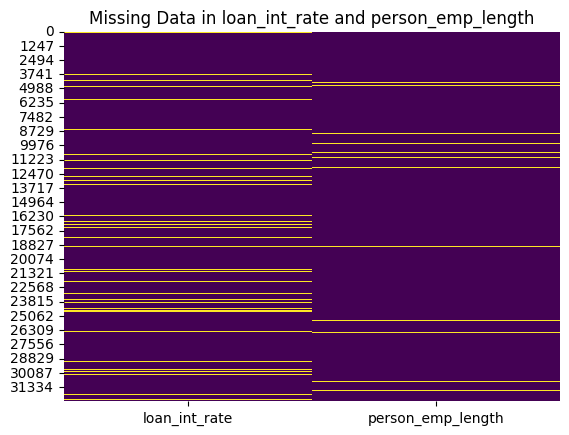

In [68]:
sns.heatmap(df[['loan_int_rate', 'person_emp_length']].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data in loan_int_rate and person_emp_length')
plt.show()

### person_emp_length

In [69]:
correlation_emp_length = round(df['person_emp_length'].corr(df['loan_status']),2)
print(f"Correlation between person_emp_length and loan_status: {correlation_emp_length}")

Correlation between person_emp_length and loan_status: -0.08


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


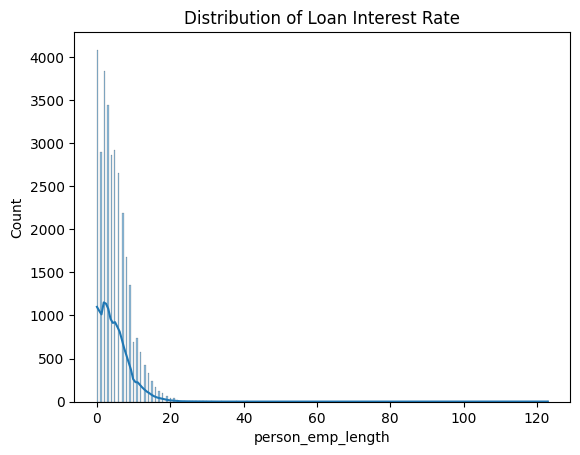

In [70]:
sns.histplot(df['person_emp_length'], kde=True)
plt.title('Distribution of Loan Interest Rate')
plt.show()

In [71]:
df['person_emp_length']=df['person_emp_length'].fillna(df['person_emp_length'].median())

as person_emp_length has only 2.74% missing we can also drop it, but we will fill it with median 

### loan_int_rate

In [72]:
correlation_emp_length = round(df['loan_int_rate'].corr(df['loan_status']),2)
print(f"Correlation between person_emp_length and loan_status: {correlation_emp_length}")

Correlation between person_emp_length and loan_status: 0.34


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


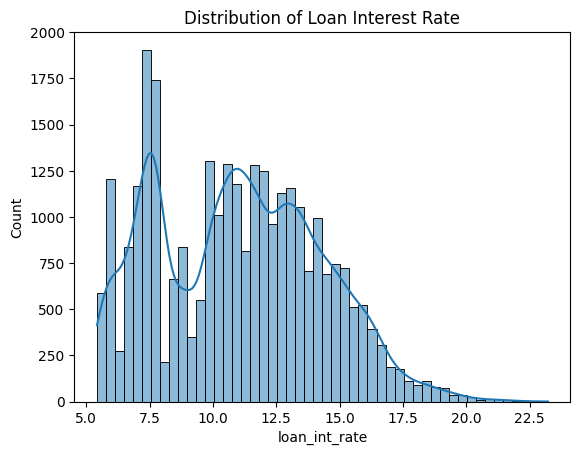

In [73]:
sns.histplot(df['loan_int_rate'], kde=True)
plt.title('Distribution of Loan Interest Rate')
plt.show()

In [74]:
df['loan_int_rate']=df['loan_int_rate'].fillna(df['loan_int_rate'].median())

## Analysis

In [75]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [76]:
df.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [77]:
numerical = ['person_age', 'person_income', 'person_emp_length', 
             'loan_amnt','loan_int_rate', 
             'loan_percent_income', 'cb_person_cred_hist_length','loan_status']
categorical = ['person_home_ownership', 'loan_intent','loan_grade',
               'cb_person_default_on_file','loan_status']

### univariate

In [78]:
def uni_analysis_numerical(df,column):
    fig,axis=plt.subplots(1,2,figsize=(14,6))
    sns.histplot(df[column], stat='density',kde=True,ax=axis[0])
    axis[0].set_title(f'distribution of {column}',fontsize=16)
    
    skewness_value = skew(df[column])
    kurtosis_value = kurtosis(df[column])
    mean_value=df[column].mean()
    median_value=df[column].median()
    std_dev=df[column].std()
    coef_variation=(std_dev/mean_value)*100

    stats=f"""Mean : {mean_value:.2f}\nMedian : {median_value:.2f}
        std_dev : {std_dev:.2f}\ncoef_variation : {coef_variation:.2f}%
        Min : {df[column].min()}\nMax : {df[column].max()}\n
        Skewness: {skewness_value:.2f}\nKurtosis: {kurtosis_value:.2f}"""
    axis[0].text(0.95, 0.95, stats, transform=axis[0].transAxes,
                 ha='right', va='top', fontsize=16 )
    
    probplot(df[column], dist="norm", plot=axis[1])
    axis[1].set_title(f'Q-Q plot for {column}',fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14,6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}',fontsize=16)
    plt.show()
    
    print(f"Skewness of {column}: {skewness_value:.2f}")
    print(f"Kurtosis of {column}: {kurtosis_value:.2f}")

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"""\nOutliers detected in {column}: {outliers.shape[0]}, df shape:{df.shape[0]}""")

    
    

**note: Kurtosis obtained using Fisher’s definition of kurtosis (kurtosis of normal == 0.0).**

### person_age

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


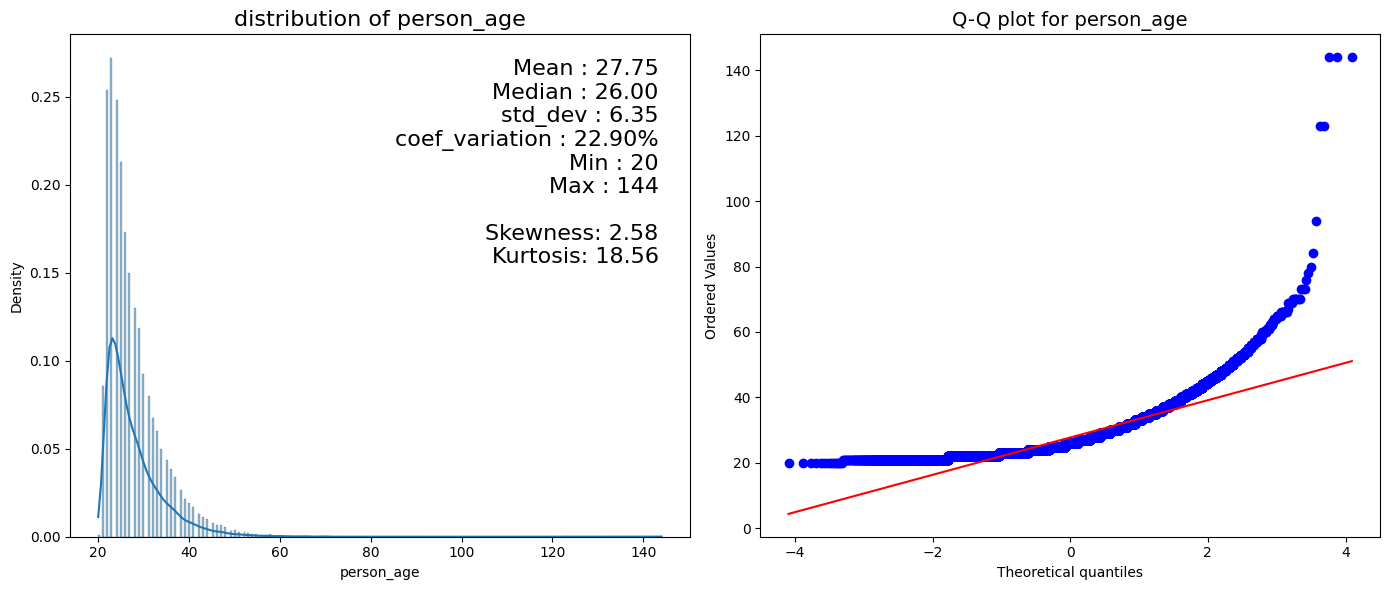

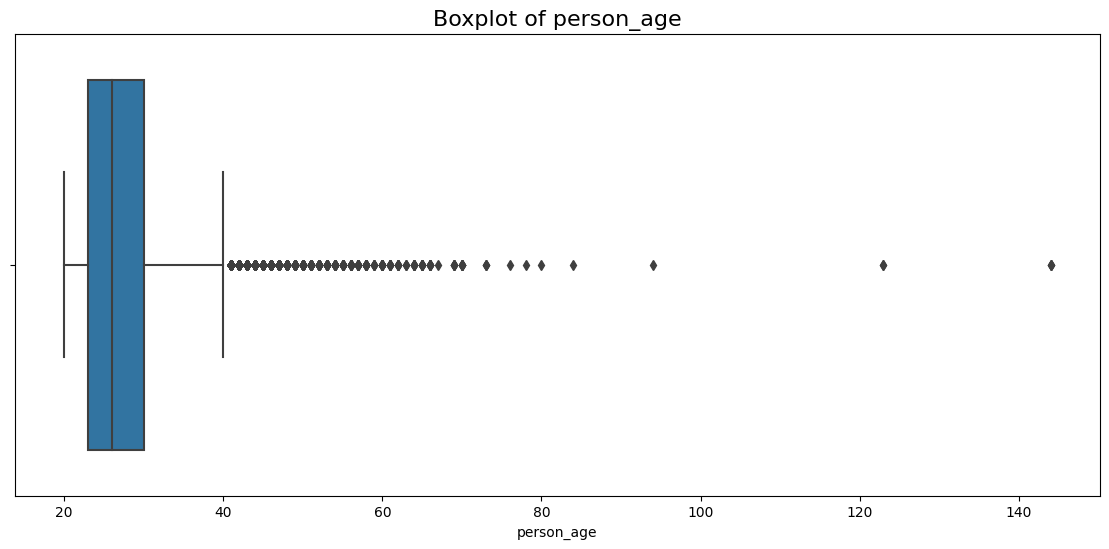

Skewness of person_age: 2.58
Kurtosis of person_age: 18.56

Outliers detected in person_age: 1491, df shape:32416


In [79]:
uni_analysis_numerical(df,numerical[0])

Interpretation
- Skewness: 2.58 = distribution of person_age is right-skewed, meaning there are more younger individuals in the dataset and a smaller number of older individuals.
  
- Kurtosis: The kurtosis value of 18.56 is quite large, indicating that the distribution of person_age has heavy tails. This could mean that there are outliers, such as very old individuals, that are far from the mean.

### person_income

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


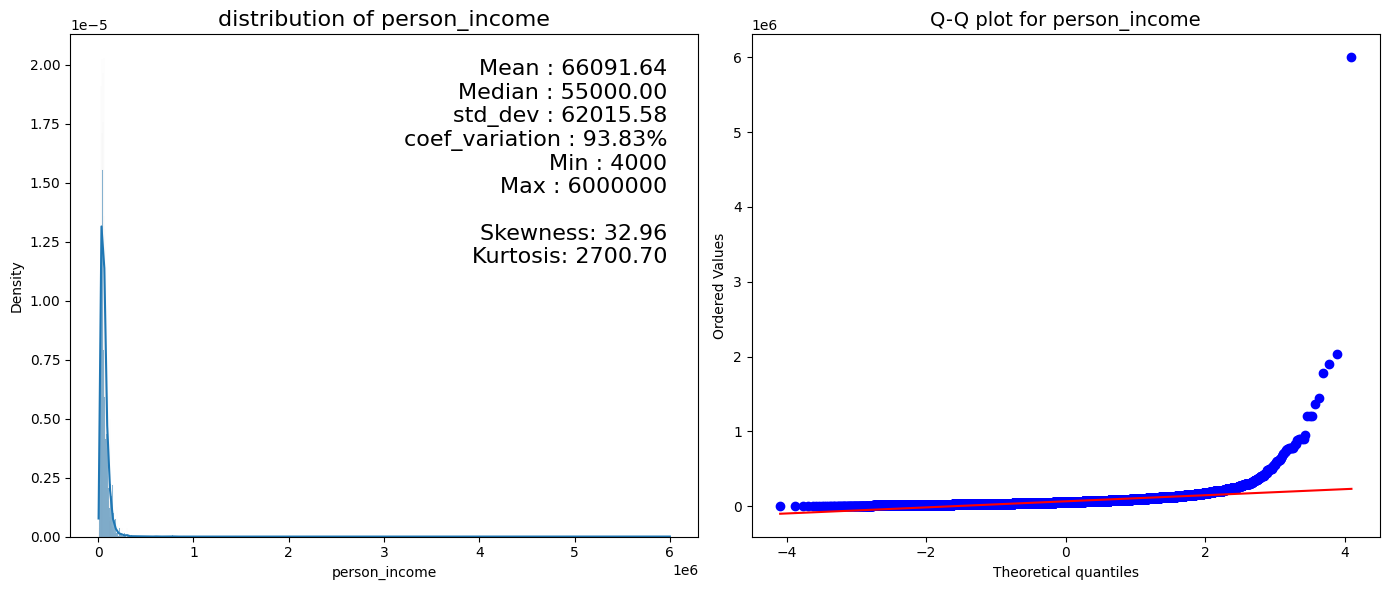

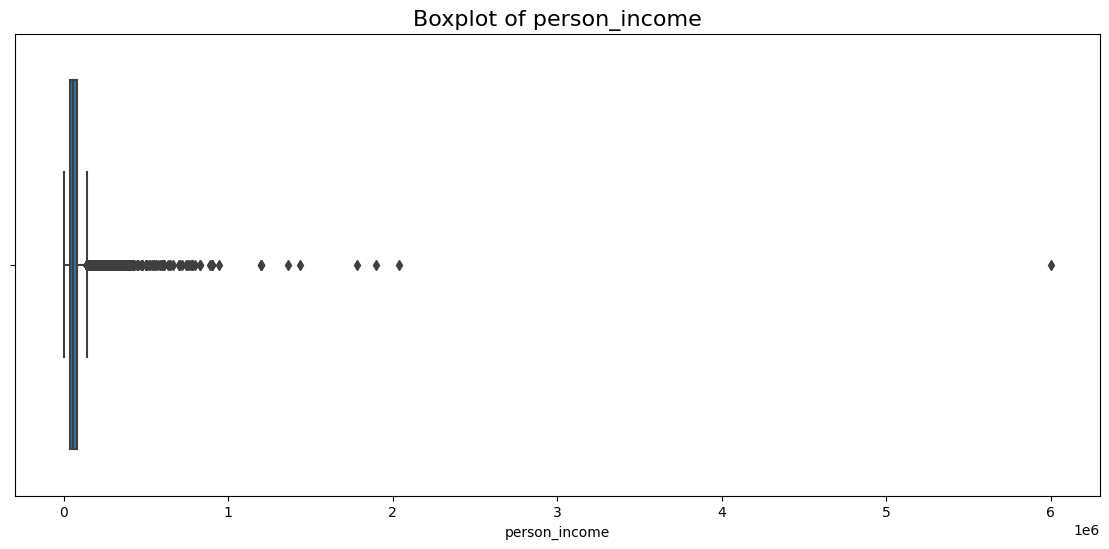

Skewness of person_income: 32.96
Kurtosis of person_income: 2700.70

Outliers detected in person_income: 1478, df shape:32416


In [80]:
uni_analysis_numerical(df,numerical[1])

Interpretation

- Skewness: 32.96 is extremely high, meaning there are many smaller values, but a few outliers pulling the distribution to the right. This suggests that a small number of individuals have very high income, while most people earn much less.

- Kurtosis: 2700.70 is extremely high, meaning the dataset has very heavy tails and extreme outliers. There are a large number of extreme values, meaning some people have abnormally high incomes compared to the majority.


### person_emp_length

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


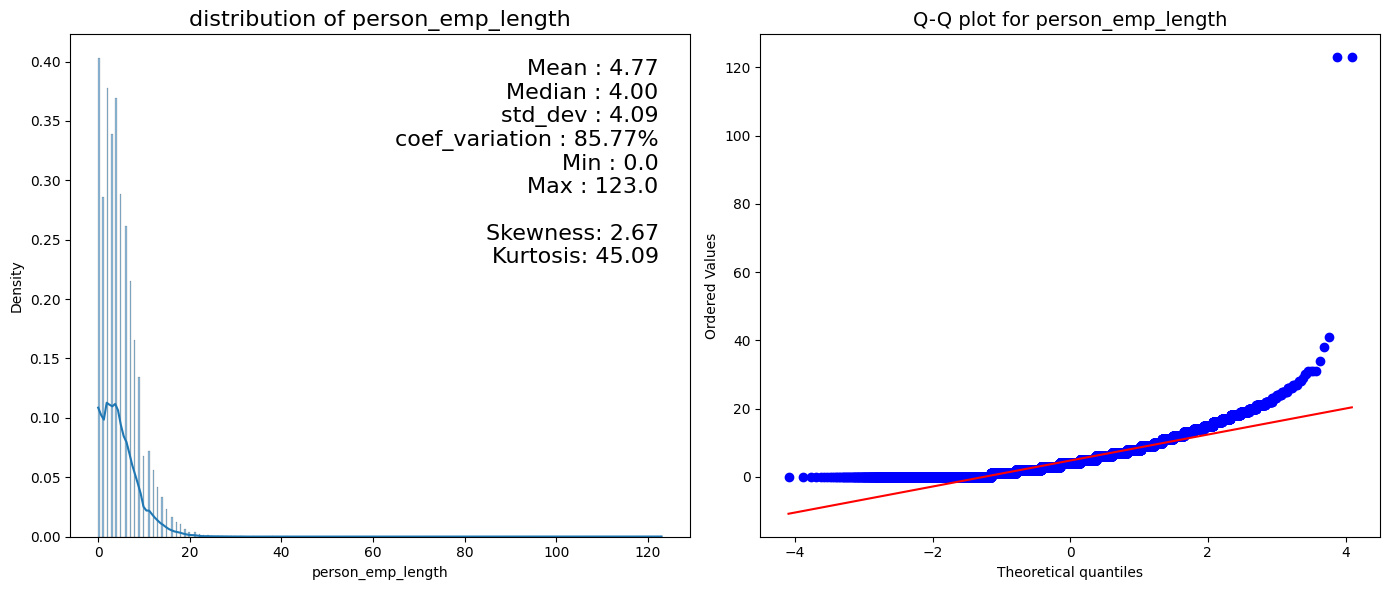

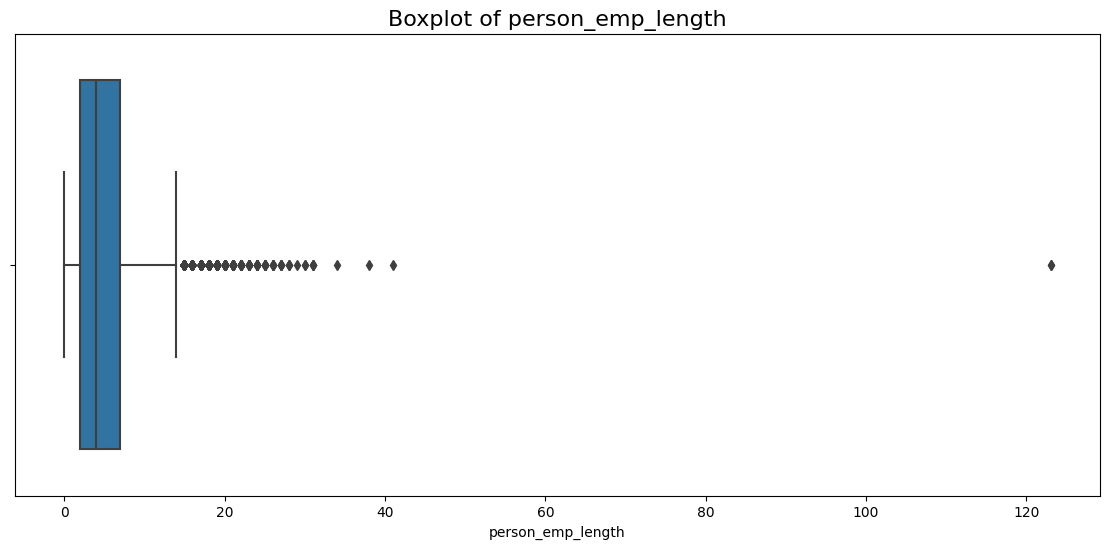

Skewness of person_emp_length: 2.67
Kurtosis of person_emp_length: 45.09

Outliers detected in person_emp_length: 852, df shape:32416


In [81]:
uni_analysis_numerical(df,numerical[2])

Interpretation 
- Skewness: 2.67 = It indicates strong right skew.This suggests that most employees have a shorter tenure, but a few individuals have exceptionally long employment durations, pulling the distribution to the right.

- Kurtosis: 45.09 = Extremely high kurtosis (45.09) means the distribution has very heavy tails. 1. This indicates a high presence of extreme values (outliers), meaning some people have very long employment lengths, which significantly deviates from the majority.

### loan_amnt

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


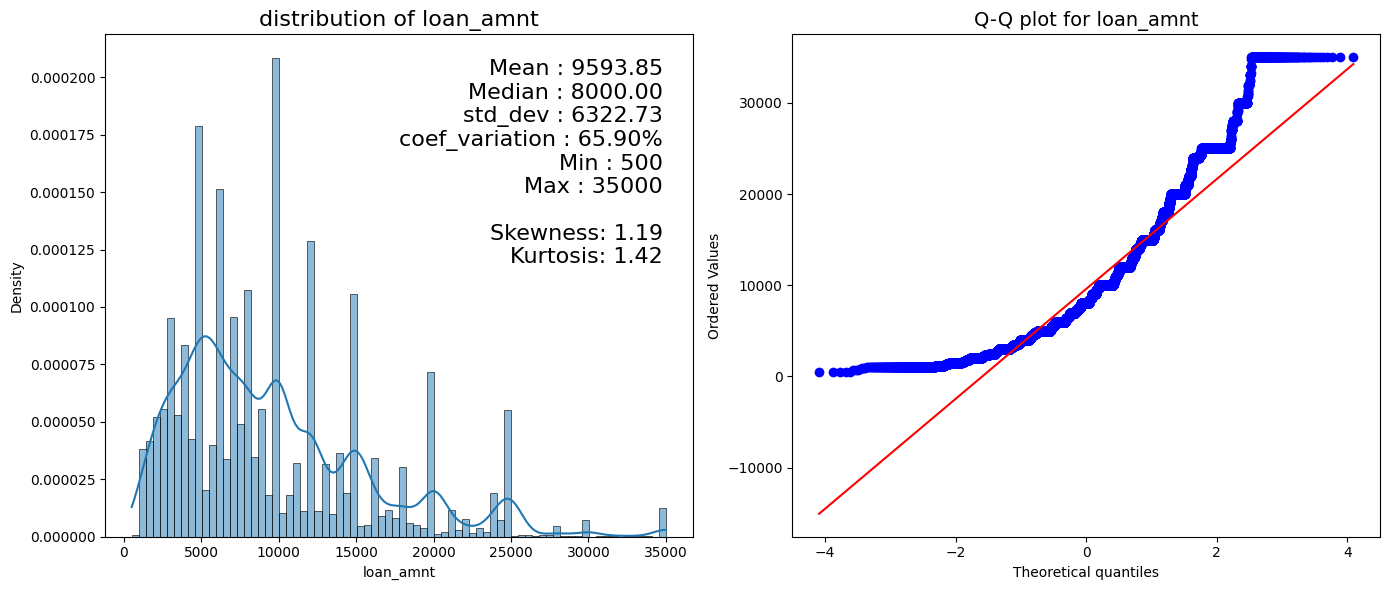

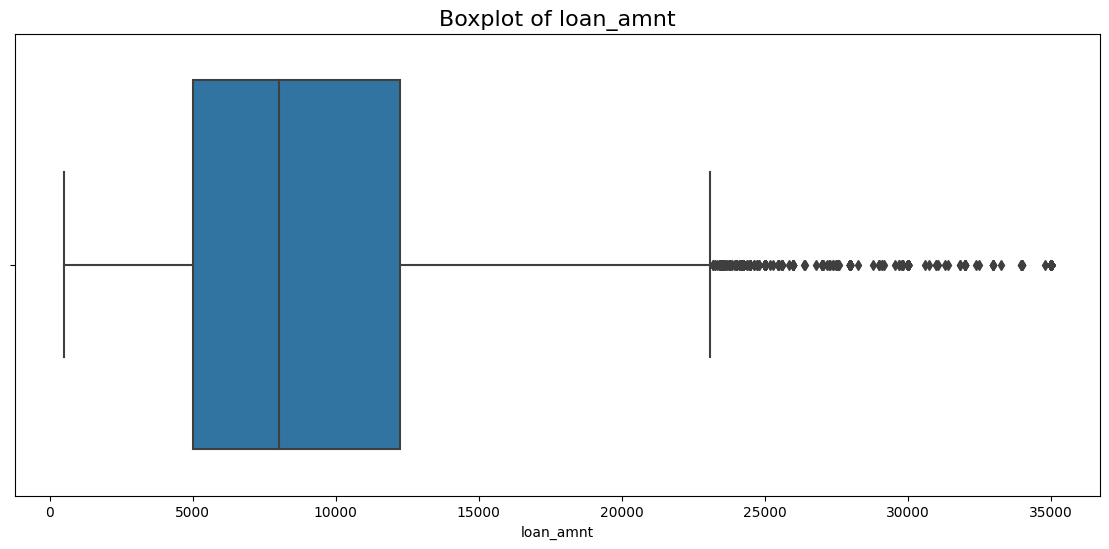

Skewness of loan_amnt: 1.19
Kurtosis of loan_amnt: 1.42

Outliers detected in loan_amnt: 1679, df shape:32416


In [82]:
uni_analysis_numerical(df,numerical[3])

Interpreting 
- Skewness: 1.19 = Skewness greater than 1 indicates a moderate right-skew, means distribution of loan_amnt has a tail on the right side. There are more smaller loan amounts, but some loans are relatively large, pulling the distribution to the right.

- Kurtosis: 1.42 = A positive kurtosis of 1.42 means the distribution is leptokurtic, having heavier tails. This suggests that there are outliers in the dataset, with a higher presence of larger loan amounts.

### loan_int_rate

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


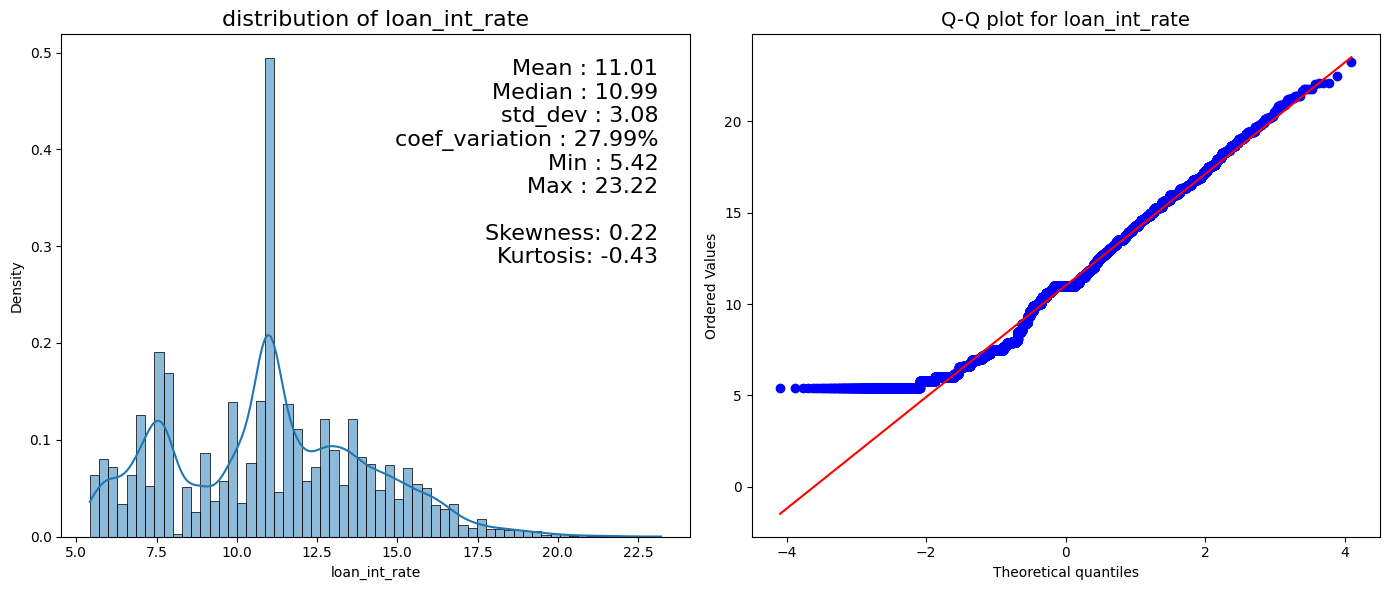

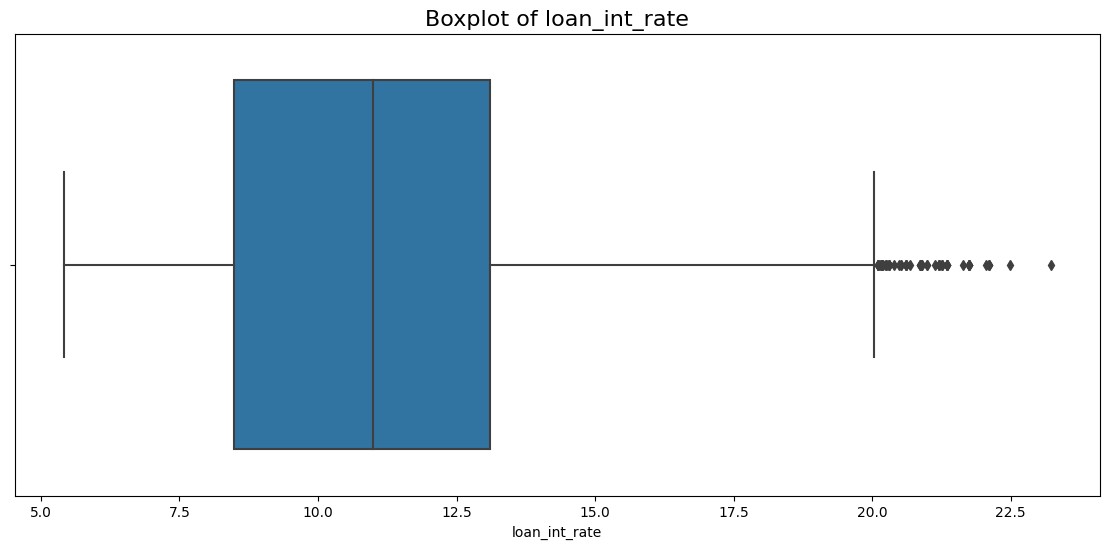

Skewness of loan_int_rate: 0.22
Kurtosis of loan_int_rate: -0.43

Outliers detected in loan_int_rate: 70, df shape:32416


In [83]:
uni_analysis_numerical(df,numerical[4])

Interpretation

- Skewness: 0.22 = It indicates a slight right skew. This suggests that the distribution of loan interest rates is nearly symmetric, with a small tendency for higher interest rates to appear more frequently than lower ones.

- Kurtosis: -0.43 = A negative kurtosis value indicates a platykurtic distribution, meaning the distribution has lighter tails than a normal distribution. This suggests fewer extreme values, indicating that loan interest rates are more evenly spread without significant outliers.

### loan_percent_income

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


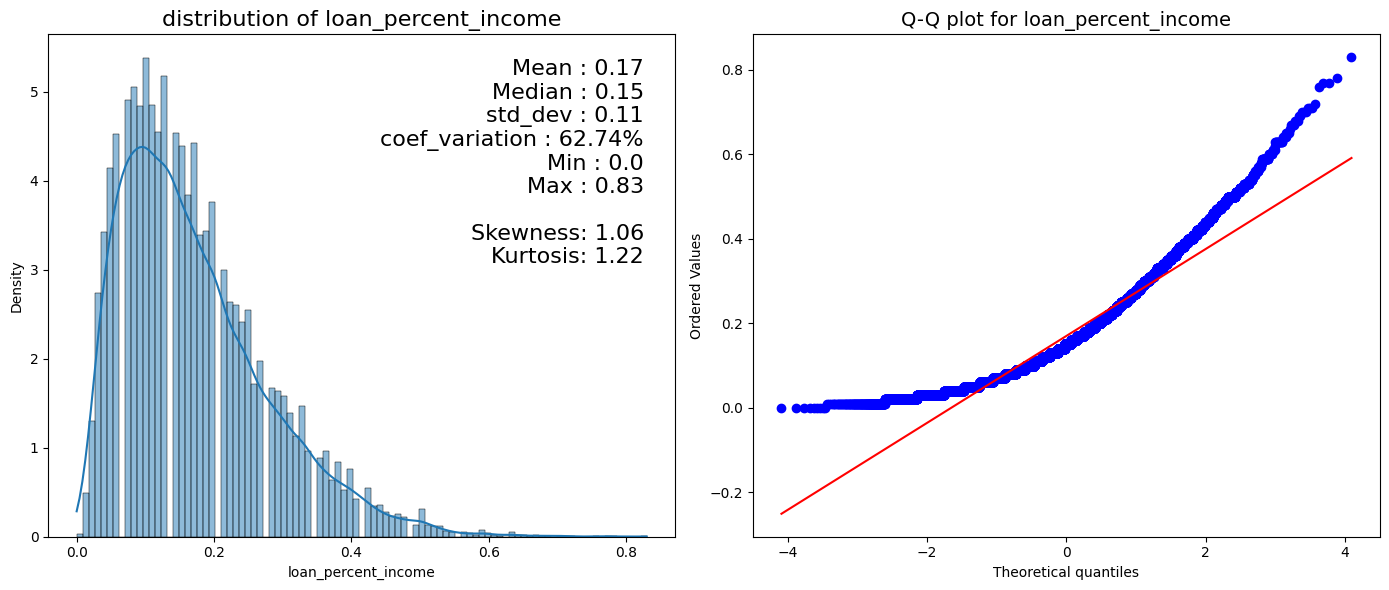

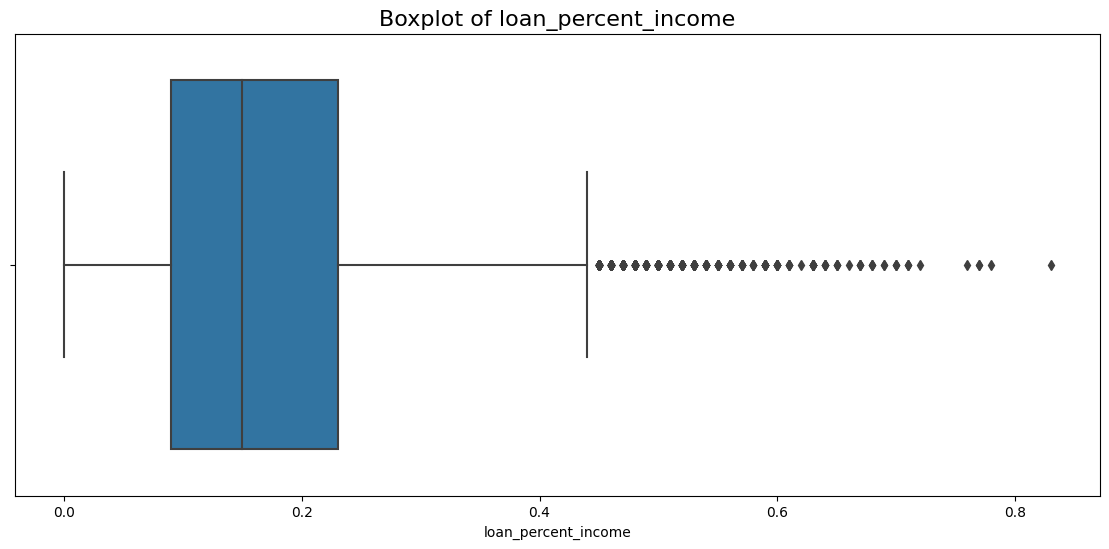

Skewness of loan_percent_income: 1.06
Kurtosis of loan_percent_income: 1.22

Outliers detected in loan_percent_income: 650, df shape:32416


In [89]:
uni_analysis_numerical(df,numerical[5])

In [84]:
numerical[3]
numerical

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_status']

<Axes: >

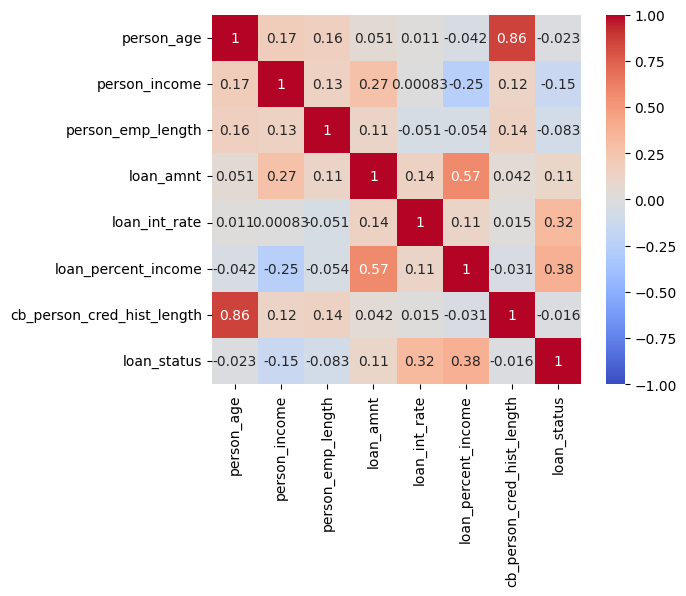

In [85]:
corr_matrix=df[numerical].corr()
sns.heatmap(corr_matrix ,  square = True, annot = True,
           cmap='coolwarm', vmin=-1, vmax=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


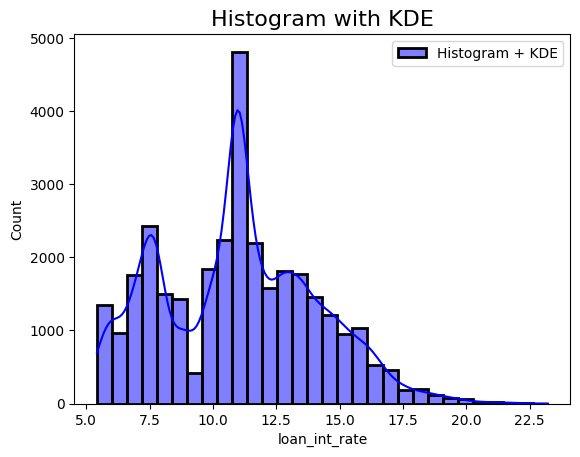

In [86]:
sns.histplot(df['loan_int_rate'], kde=True, bins=30, 
             color='blue', linewidth=2, label='Histogram + KDE')
plt.title('Histogram with KDE', fontsize=16)
plt.legend()
plt.show()


In [87]:
df['loan_int_rate']=df['loan_int_rate'].fillna(df['loan_int_rate'].median())

print(f"Missing values after imputation: {df['loan_int_rate'].isnull().sum()}")

Missing values after imputation: 0
